# Task 2: Symbolic, Conditioned Generation

## Setup

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt

from music21 import corpus, note, chord, stream, interval
import mido
from collections import defaultdict, Counter

SEED           = 420
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

INPUT_DIM      = 12
HIDDEN_UNITS   = 512
HIDDEN_UNITS2   = 64
OUTPUT_DIM     = 12
DROPOUT_RATE   = 0.1

EPOCHS         = 200
BATCH_SIZE     = 32
LEARNING_RATE  = 1e-3
VAL_RATIO      = 0.2

MEASURE_LENGTH = 4.0

WEIGHTS_PATH   = "best_bach_mlp_roots_augmented.pt"

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

## Exploratory Data Analysis

    root_pc  count root_name
5         0     26         C
11        1      4     C♯/D♭
4         2     59         D
9         3     13     D♯/E♭
2         4     38         E
3         5     24         F
6         6     16     F♯/G♭
0         7     83         G
10        8      2     G♯/A♭
1         9     60         A
7        10     29     A♯/B♭
8        11     22         B


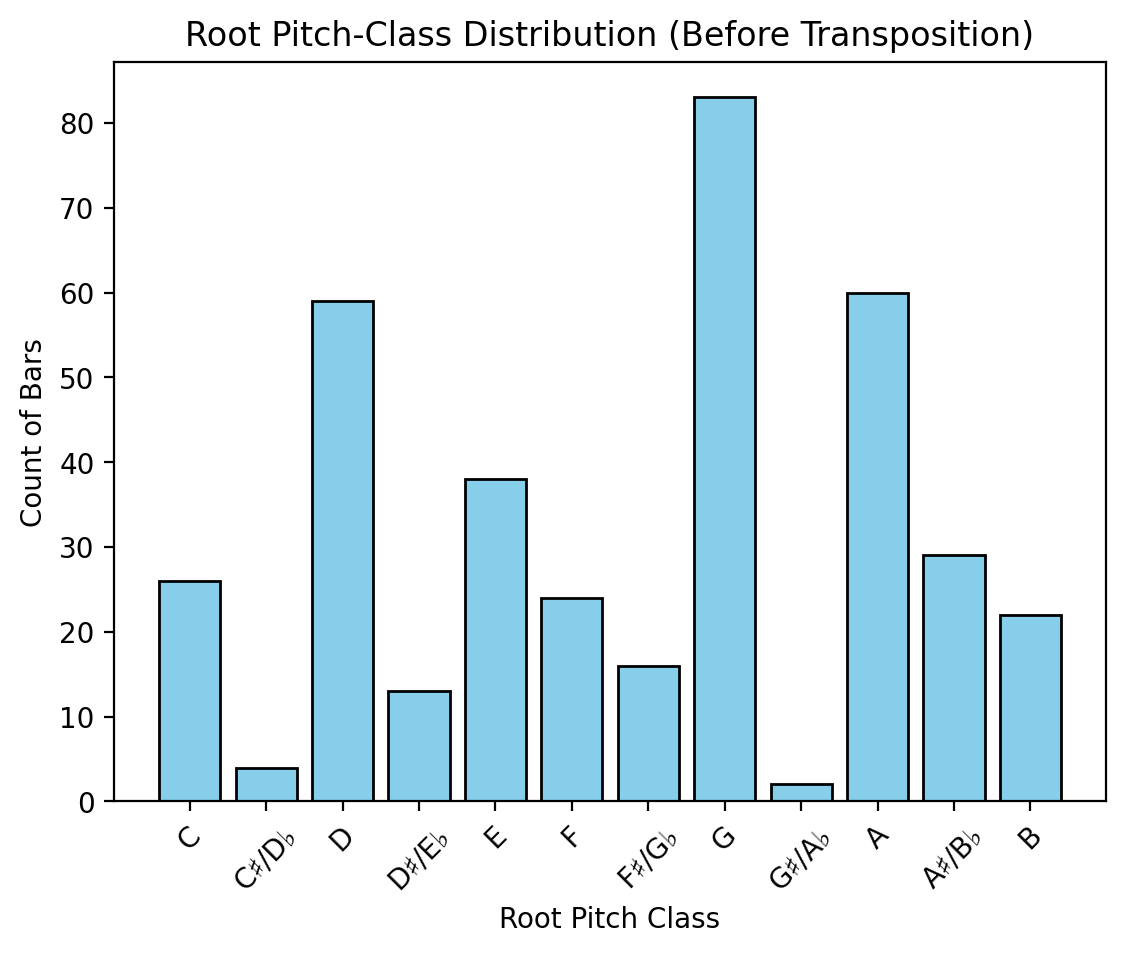

In [5]:
# 1) Extract bars & roots per chorale
def extract_measure_data(score_obj):
    MEASURE_LENGTH = 4.0
    if isinstance(score_obj, stream.Opus):
        seq = []
        for sub in score_obj:
            seq.extend(extract_measure_data(sub))
        return seq

    parts = score_obj.parts
    soprano_events = [ev for ev in parts[0].recurse()
                      .getElementsByClass((note.Note, chord.Chord))]
    bass_events = [ev for ev in parts[-1].recurse()
                   .getElementsByClass((note.Note, chord.Chord))]

    total_q = score_obj.highestTime
    n_bars = int(np.ceil(total_q / MEASURE_LENGTH))
    bar_data = []

    for i in range(n_bars):
        start_t, end_t = i*4.0, (i+1)*4.0
        hist = np.zeros(12, dtype=int)
        for ev in soprano_events:
            if start_t <= ev.offset < end_t:
                pc = ev.pitch.pitchClass if isinstance(ev, note.Note) \
                     else max(p.pitchClass for p in ev.pitches)
                hist[pc] += 1
        if hist.sum() == 0: continue

        cands = [ev for ev in bass_events if start_t <= ev.offset < end_t]
        if not cands: continue
        best_b = min(cands, key=lambda ev: abs(ev.offset - start_t))
        root_pc = best_b.pitch.pitchClass
        bar_data.append((tuple(hist), root_pc))

    return bar_data

chorale_bar_counts = []
root_counts = Counter()

for idx, score in enumerate(corpus.chorales.Iterator()):
    bars = extract_measure_data(score)
    n_bars = len(bars)
    if n_bars > 0:
        chorale_bar_counts.append({'chorale_id': idx+1, 'n_bars': n_bars})
        for _, root in bars:
            root_counts[root] += 1

# 4) Root distribution (before augmentation)
pc_names = ['C','C♯/D♭','D','D♯/E♭','E','F','F♯/G♭','G','G♯/A♭','A','A♯/B♭','B']
root_df = pd.DataFrame({'root_pc': list(root_counts.keys()),
                        'count': list(root_counts.values())})
root_df['root_name'] = root_df['root_pc'].apply(lambda x: pc_names[x])
root_df = root_df.sort_values('root_pc')
print(root_df)

# 5) Plot root distribution
plt.bar(root_df['root_name'], root_df['count'], color='skyblue', edgecolor='black')
plt.title("Root Pitch-Class Distribution (Before Transposition)")
plt.xlabel("Root Pitch Class")
plt.ylabel("Count of Bars")
plt.xticks(rotation=45)
plt.show()

## Data Processing

In [4]:
# ── 2) EXTRACT (histogram → root) FROM ONE Score or Opus ─────────────────────────
def extract_measure_examples(obj):
    if isinstance(obj, stream.Opus):
        seq = []
        for sub in obj:
            try:
                seq.extend(extract_measure_examples(sub))
            except Exception:
                continue
        return seq

    score = obj
    parts = score.parts
    if len(parts) < 1:
        return []

    soprano_events = [
        ev for ev in parts[0].recurse().getElementsByClass((note.Note, chord.Chord))
    ]
    bass_events = [
        ev for ev in parts[-1].recurse().getElementsByClass((note.Note, chord.Chord))
    ]

    total_q = score.highestTime
    n_bars  = int(np.ceil(total_q / MEASURE_LENGTH))
    examples = []

    for i in range(n_bars):
        start_t = i * MEASURE_LENGTH
        end_t   = start_t + MEASURE_LENGTH

        # build a 12‐dim histogram over soprano_events in [start_t, end_t)
        hist = np.zeros(12, dtype=np.float32)
        for ev in soprano_events:
            if start_t <= ev.offset < end_t:
                if isinstance(ev, note.Note):
                    pc = ev.pitch.pitchClass
                else:  # chord.Chord
                    pc = max(p.pitchClass for p in ev.pitches)
                hist[pc] += 1.0
        if hist.sum() < 1e-6:
            # skip bars with no soprano events
            continue
        hist /= hist.sum()

        # find bass event closest to downbeat
        candidates = [ev for ev in bass_events if start_t <= ev.offset < end_t]
        if not candidates:
            continue
        best_bass = min(candidates, key=lambda ev: abs(ev.offset - start_t))
        root_pc   = best_bass.pitch.pitchClass

        examples.append((hist, root_pc))

    return examples


# ── 3) BUILD AUGMENTED DATASET FROM BACH CHORALES ─────────────────────────────────
def build_bach_chorale_examples_augmented():
    """
    Iterate through each chorale in music21.corpus.chorales.Iterator().
    For each Score:
      • For each transposition interval from 0 to 11 semitones:
          – Make a copy of the Score, transpose by that many semitones.
          – Extract (hist, root) pairs via extract_measure_examples().
          – Collect all pairs.
    Returns a flat list of (hist, root) across all transpositions of all chorales.
    """
    all_examples = []
    iterator = corpus.chorales.Iterator()

    g = 0
    for score in iterator:
        for semitone in range(12):
            try:
                transposed = score.transpose(semitone)
            except Exception:
                print('E')
                continue

            try:
                exs = extract_measure_examples(transposed)
            except Exception:
                print('E2')
                continue

            all_examples.extend(exs)
        if g % 10 == 0:
            print(f'done with score {g}')
        g += 1

    return all_examples


print("⏳ 1) Extracting & augmenting bars from all Bach chorales …")
all_data = build_bach_chorale_examples_augmented()
print(f"   → Total augmented bars: {len(all_data)}\n")

# Shuffle and split 80/20
random.shuffle(all_data)
split_idx = int((1 - VAL_RATIO) * len(all_data))
train_data = all_data[:split_idx]
val_data   = all_data[split_idx:]

print(f"Training bars:   {len(train_data)}")
print(f"Validation bars: {len(val_data)}\n")


# ── 4) TORCH DATASET FOR (hist, root) PAIRS ──────────────────────────────────────
class BarDataset(Dataset):
    def __init__(self, examples):
        self.hists = [torch.tensor(e[0], dtype=torch.float32) for e in examples]
        self.labs  = [torch.tensor(e[1], dtype=torch.long)   for e in examples]

    def __len__(self):
        return len(self.hists)

    def __getitem__(self, idx):
        return self.hists[idx], self.labs[idx]


train_ds = BarDataset(train_data)
val_ds   = BarDataset(val_data)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

## Model Training

In [253]:
class ContextualMLP(nn.Module):
    def __init__(self, input_dim=12, hidden1=32, hidden2=1024, hidden3=64, output_dim=12, dropout=0.08):
        super().__init__()
        # Layer 1
        self.fc1    = nn.Linear(input_dim, hidden1)
        self.bn1    = nn.BatchNorm1d(hidden1)
        self.drop1  = nn.Dropout(dropout)

        # Layer 2
        self.fc2    = nn.Linear(hidden1, hidden2)
        self.bn2    = nn.BatchNorm1d(hidden2)
        self.drop2  = nn.Dropout(dropout)

        # Layer 3
        self.fc3    = nn.Linear(hidden2, hidden3)
        self.bn3    = nn.BatchNorm1d(hidden3)
        self.drop3  = nn.Dropout(dropout)

        # Final classification
        self.fc4    = nn.Linear(hidden3, output_dim)

        # If we want a “residual” from fc1→fc3, we need to map hidden1→hidden3 if dims differ
        if hidden1 != hidden3:
            self.residual_mapper = nn.Linear(hidden1, hidden3)
        else:
            self.residual_mapper = None

    def forward(self, x):
        h1 = self.fc1(x)
        h1 = self.bn1(h1)
        h1 = F.relu(h1)
        h1 = self.drop1(h1)

        h2 = self.fc2(h1)
        h2 = self.bn2(h2)
        h2 = F.relu(h2)
        h2 = self.drop2(h2)

        h3 = self.fc3(h2
        h3 = self.bn3(h3)

        if self.residual_mapper is not None:
            res = self.residual_mapper(h1)
        else:
            res = h1

        h3 = F.relu(h3 + res)
        h3 = self.drop3(h3)

        logits = self.fc4(h3)
        return logits



model = ContextualMLP().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-7)
criterion = nn.CrossEntropyLoss()


# ── 6) TRAIN & VALIDATE ─────────────────────────────────────────────────────────
best_val_loss = float("inf")
patience = 3
no_improve = 0

print("⏳ 2) Training MLP on augmented Bach chorale bars …")
for epoch in range(1, EPOCHS + 1):
    # TRAIN
    model.train()
    train_loss = 0.0
    train_count = 0

    for x, y in train_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        train_count += x.size(0)

    train_loss /= train_count

    # VALIDATE
    model.eval()
    val_loss = 0.0
    val_count = 0
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            logits = model(x)
            loss = criterion(logits, y)
            val_loss += loss.item() * x.size(0)
            val_count += x.size(0)
    val_loss /= val_count

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), WEIGHTS_PATH)
        print("  → Saved new best weights.")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("  → Early stopping.\n")
            break

print(f"✅ Training complete. Best validation loss = {best_val_loss:.4f}\n")

⏳ 2) Training MLP on augmented Bach chorale bars …
Epoch 01 | Train Loss: 1.5396 | Val Loss: 1.1341
  → Saved new best weights.
Epoch 02 | Train Loss: 1.1815 | Val Loss: 1.0469
  → Saved new best weights.
Epoch 03 | Train Loss: 1.1230 | Val Loss: 1.0163
  → Saved new best weights.
Epoch 04 | Train Loss: 1.0797 | Val Loss: 1.0164
Epoch 05 | Train Loss: 1.0571 | Val Loss: 0.9907
  → Saved new best weights.
Epoch 06 | Train Loss: 1.0240 | Val Loss: 0.9817
  → Saved new best weights.
Epoch 07 | Train Loss: 1.0332 | Val Loss: 0.9912
Epoch 08 | Train Loss: 1.0043 | Val Loss: 0.9716
  → Saved new best weights.
Epoch 09 | Train Loss: 0.9855 | Val Loss: 0.9587
  → Saved new best weights.
Epoch 10 | Train Loss: 0.9803 | Val Loss: 0.9590
Epoch 11 | Train Loss: 0.9591 | Val Loss: 0.9444
  → Saved new best weights.
Epoch 12 | Train Loss: 0.9670 | Val Loss: 0.9270
  → Saved new best weights.
Epoch 13 | Train Loss: 0.9424 | Val Loss: 0.9377
Epoch 14 | Train Loss: 0.9408 | Val Loss: 0.9489
Epoch 15 | 

In [254]:
# ── 7) INFERENCE: ONE‐CHORD‐PER‐BAR FOR A LOCAL MIDI ─────────────────────────────
def harmonize(midi_path):
    """
    1) Load local MIDI via mido (polyphony OK).
    2) Extract monophonic soprano: highest note per tick.
    3) Split into fixed 4/4 bars by tick: build 12‐dim histogram per bar.
    4) Feed each histogram into trained MLP → root_pc.
    5) Overlay one major triad per bar under original tracks and save
       as <stem>_one_chord_bach_augmented.mid.
    """
    if not os.path.isfile(midi_path):
        print(f"Error: '{midi_path}' not found.")
        return

    mid = mido.MidiFile(midi_path)
    tpb = mid.ticks_per_beat
    ticks_per_bar = tpb * 4

    raw_events = []
    for tr in mid.tracks:
        abs_t = 0
        for msg in tr:
            abs_t += msg.time
            if msg.type == 'note_on' and msg.velocity > 0:
                raw_events.append((abs_t, msg.note))
    if not raw_events:
        print("No note_on events found.")
        return

    by_tick = defaultdict(list)
    for t, n in raw_events:
        by_tick[t].append(n)
    sopr = [(t, max(ns)) for t, ns in by_tick.items()]

    max_tick = max(t for t, _ in sopr)
    n_bars = (max_tick // ticks_per_bar) + 1

    preds = []
    for i in range(n_bars):
        st = i * ticks_per_bar
        et = st + ticks_per_bar
        hist = np.zeros(12, dtype=np.float32)
        for t, n in sopr:
            if st <= t < et:
                hist[n % 12] += 1.0
        if hist.sum() < 1e-6:
            root_pc = 0
        else:
            hist /= hist.sum()
            ht = torch.tensor(hist, dtype=torch.float32).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                logits = model(ht)
                root_pc = torch.argmax(logits, dim=-1).item()
        preds.append(root_pc)

    chord_track = mido.MidiTrack()
    for root_pc in preds:
        base = 60 + (root_pc % 12)
        third = base + 4
        fifth = base + 7
        chord_track.append(mido.Message('note_on', channel=0, note=base, velocity=64, time=0))
        chord_track.append(mido.Message('note_on', channel=0, note=third, velocity=64, time=0))
        chord_track.append(mido.Message('note_on', channel=0, note=fifth, velocity=64, time=0))
        chord_track.append(mido.Message('note_off', channel=0, note=base, velocity=64, time=ticks_per_bar))
        chord_track.append(mido.Message('note_off', channel=0, note=third, velocity=64, time=0))
        chord_track.append(mido.Message('note_off', channel=0, note=fifth, velocity=64, time=0))

    chord_track.append(mido.MetaMessage('end_of_track', time=1))

    new_mid = mido.MidiFile()
    new_mid.ticks_per_beat = mid.ticks_per_beat
    for tr in mid.tracks:
        new_mid.tracks.append(tr.copy())
    new_mid.tracks.append(chord_track)

    stem = os.path.splitext(os.path.basename(midi_path))[0]
    out = f"{stem}_harmonized.mid"
    new_mid.save(out)
    print(f"Saved → {out}")

## Evaluation

Validation Accuracy:  74.20%


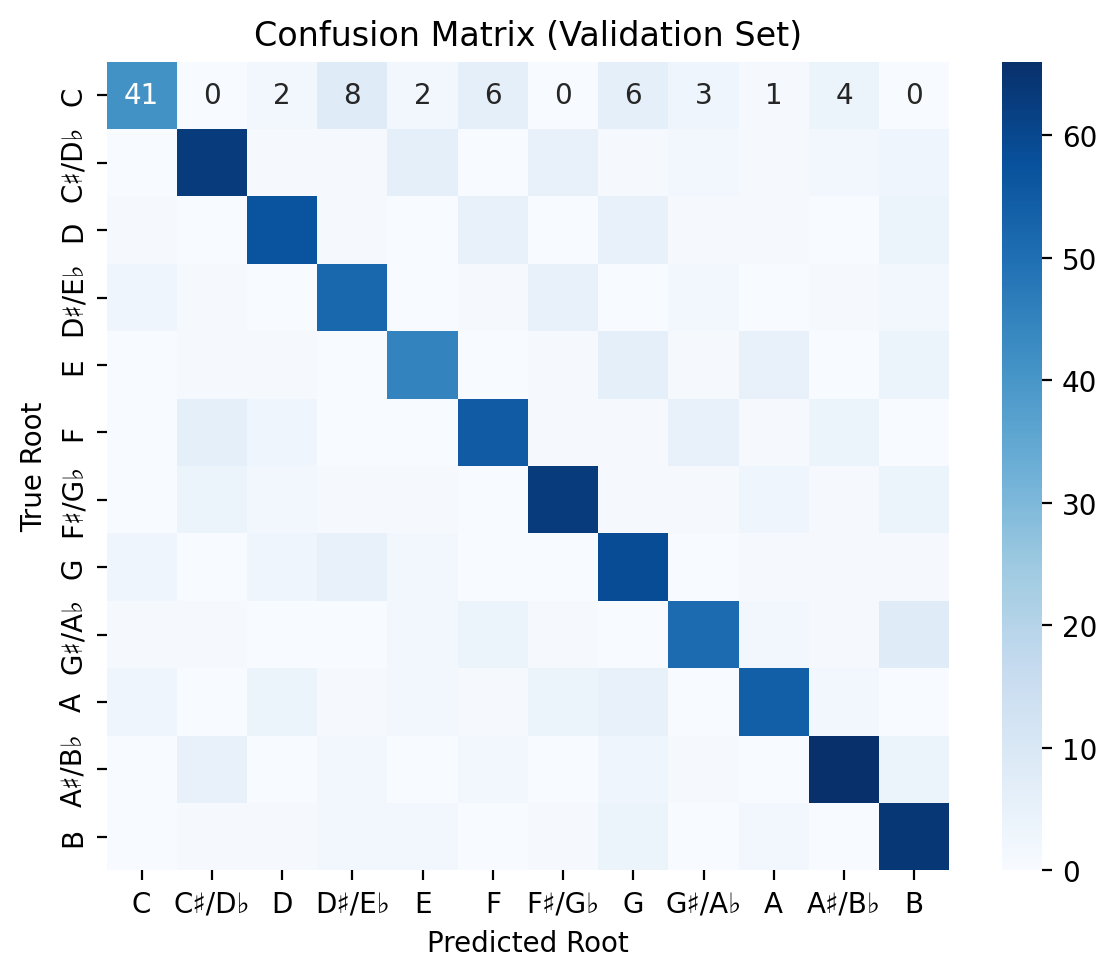

In [261]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, top_k_accuracy_score

# 1) Load trained model & validation DataLoader
model.load_state_dict(torch.load(WEIGHTS_PATH))
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x = x_batch.to(DEVICE)
        y = y_batch.to(DEVICE)
        logits = model(x)
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(y.cpu().numpy())

preds_array   = np.concatenate(all_preds)
targets_array = np.concatenate(all_targets)

# 2) Compute Overall Accuracy and Top-2 Accuracy
acc = accuracy_score(targets_array, preds_array)

print(f"Validation Accuracy:  {acc*100:.2f}%")

# 3) Confusion Matrix
cm = confusion_matrix(targets_array, preds_array, labels=list(range(12)))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['C','C♯/D♭','D','D♯/E♭','E','F','F♯/G♭','G','G♯/A♭','A','A♯/B♭','B'],
            yticklabels=['C','C♯/D♭','D','D♯/E♭','E','F','F♯/G♭','G','G♯/A♭','A','A♯/B♭','B'])
plt.xlabel("Predicted Root")
plt.ylabel("True Root")
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()


## Harmonizing And Testing Local Midi Files

In [6]:
print("\nEnter path to a local MIDI file to harmonize\n")
path = input("MIDI path: ").strip()
harmonize(path)

In [258]:
import pygame

pygame.init()
pygame.mixer.music.load("bach_846_harmonized.mid")
pygame.mixer.music.play()